HEADER BAR DOES NOT WORK WITH QUARTO, ACCESS OTHER TABS BY CLOSING THIS ONE

# Introduction

Intro here blah blah blah

# What is Clustering and How Does It Work?

Summary info blah blah blah

# Methods

## Data Selection

Explain data sets

In [190]:
# Necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
import sklearn.cluster as cluster
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift
from sklearn.cluster import Birch
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler

'''
# Read in data frames
lookup = pd.read_csv("../../data/01-modified-data/Remote-Station-Lookup-Cleaned.csv")
fares = pd.read_csv("../../data/01-modified-data/MTA-Fare-Card-Cleaned-Gathered.csv",index_col=0)
weather = pd.read_csv("../../data/01-modified-data/NYC-Weather-Data-Cleaned.csv")
# Join data frames by remote station id
df = fares.merge(lookup,on="remote_station_id")

# Join weather data frame to overall df
df['to_date'] = pd.to_datetime(df['to_date'])
weather = weather.rename(columns={'DATE':'to_date'})
weather['to_date'] = pd.to_datetime(weather['to_date'])
df = df.merge(weather,on="to_date")
'''


'\n# Read in data frames\nlookup = pd.read_csv("../../data/01-modified-data/Remote-Station-Lookup-Cleaned.csv")\nfares = pd.read_csv("../../data/01-modified-data/MTA-Fare-Card-Cleaned-Gathered.csv",index_col=0)\nweather = pd.read_csv("../../data/01-modified-data/NYC-Weather-Data-Cleaned.csv")\n# Join data frames by remote station id\ndf = fares.merge(lookup,on="remote_station_id")\n\n# Join weather data frame to overall df\ndf[\'to_date\'] = pd.to_datetime(df[\'to_date\'])\nweather = weather.rename(columns={\'DATE\':\'to_date\'})\nweather[\'to_date\'] = pd.to_datetime(weather[\'to_date\'])\ndf = df.merge(weather,on="to_date")\n'

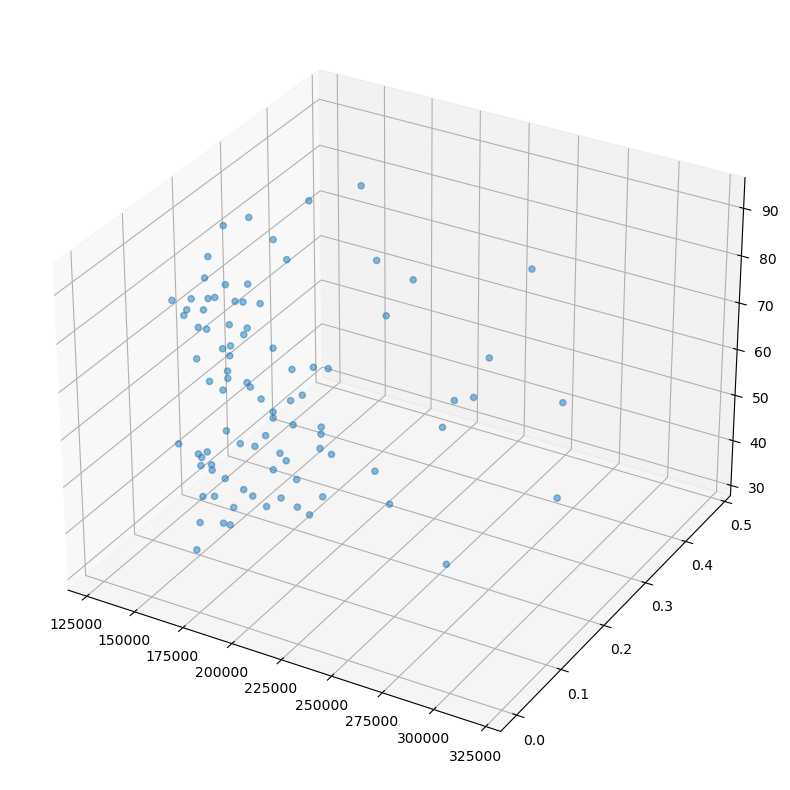

In [191]:
weather = pd.read_csv("../../data/01-modified-data/NYC-Weather-Data-Cleaned.csv",index_col=0)
mdbf = pd.read_csv("../../data/01-modified-data/MDBF-Cleaned-Merged.csv",index_col=0)

mdbf['ServiceDate'] = pd.to_datetime(mdbf['ServiceDate'])
mdbf = mdbf.groupby(pd.PeriodIndex(mdbf['ServiceDate'],freq='M'))['mdbf'].mean().reset_index()
weather['DATE'] = pd.to_datetime(weather['DATE'])
mean_weather = weather.groupby(pd.PeriodIndex(weather['DATE'],freq='M'))[['PRCP','TMAX']].mean().reset_index()
mean_weather = mean_weather.rename(columns={'DATE':"ServiceDate"})

df = mdbf.merge(mean_weather,on=['ServiceDate'])
# Variable selection
X = np.array(df.drop(columns='ServiceDate'))

# Plot initial data values
# Plot clusters
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2],alpha=0.5)
plt.show()

# Normalize data 
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)


Explain variable selection and divide into test and training

# KMeans Clustering

## Hyperparameter Tuning

### Elbow Method

Explain how it works here

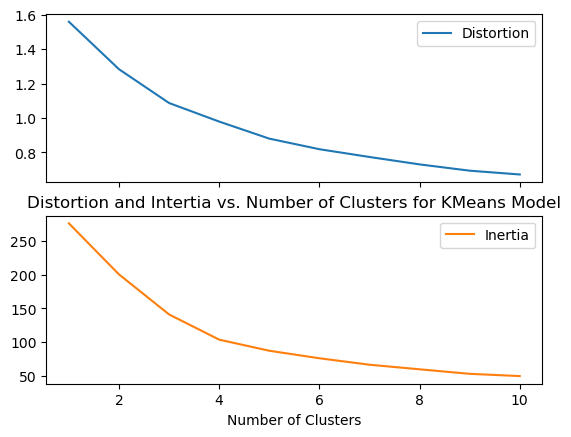

In [192]:
# Test multiple k values using ELBOW method
# Code adapted from ANLY501 lab-5.2 authored by Alex Pattarini
dists = []
inertias = []

k = 11
for k in range(1,k):
    model = KMeans(n_clusters=k,init='k-means++',random_state=0)
    model.fit(X)
    dists.append(sum(np.min(cdist(X,model.cluster_centers_,'euclidean'),axis=1))/X.shape[0])
    inertias.append(model.inertia_)
    df = pd.DataFrame({'Cluster Num':np.arange(1,k+1), 'Distortion':dists, 'Inertia':inertias})

df.plot.line(x='Cluster Num',subplots=True)
plt.title("Distortion and Intertia vs. Number of Clusters for KMeans Model")
plt.xlabel("Number of Clusters")
plt.show()


### Silhouette Scores

Explain how this works here

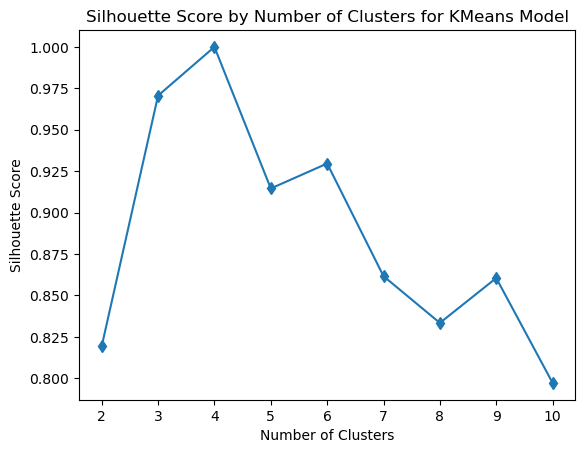

In [193]:
# Code partially adapted from Professor James Hickman's 3D-SKLEARN-CLUSTERING-EXAMPLE.py
silhouette_scores = []
n_clusters = []
for n_cluster in range(2,11):
    model = KMeans(n_clusters=n_cluster,init='k-means++',random_state=0)
    model_labels = model.fit_predict(X)
    sil_score = silhouette_score(X, model_labels)
    silhouette_scores.append(sil_score)
    n_clusters.append(n_cluster)

n_clusters=np.array(n_clusters)
silhouette_scores=np.array(silhouette_scores)
plt.plot(n_clusters,silhouette_scores/np.max(silhouette_scores), '-d')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score by Number of Clusters for KMeans Model")
plt.show()
    

Conclusion of num clusters chosen (3)

## Results of KMeans Clustering

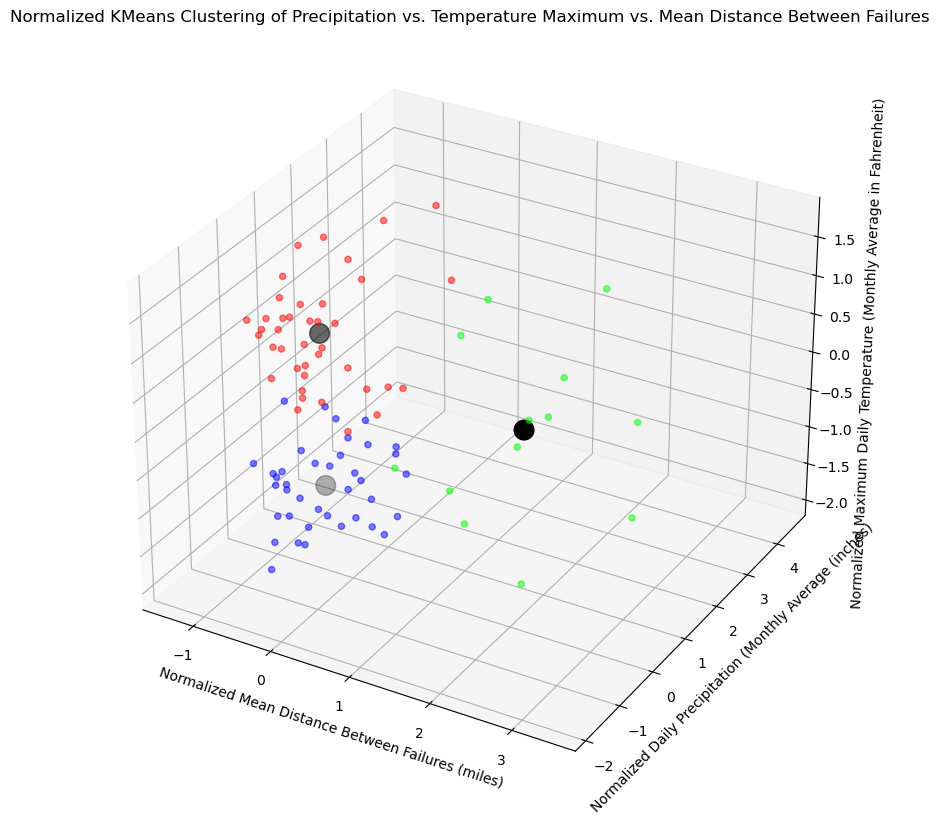

In [194]:
# Final model
model = KMeans(n_clusters=3,init='k-means++',random_state=0).fit(X)
y_kmeans = model.predict(X)
centroids = model.cluster_centers_

# Plot clusters/centroids
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2],c=y_kmeans, cmap='brg',alpha=0.5)
ax.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1],model.cluster_centers_[:,2], s=200, c='black')
ax.set_title("Normalized KMeans Clustering of Precipitation vs. Temperature Maximum vs. Mean Distance Between Failures")
ax.set_xlabel("Normalized Mean Distance Between Failures (miles)")
ax.set_zlabel("Normalized Maximum Daily Temperature (Monthly Average in Fahrenheit)")
ax.set_ylabel("Normalized Daily Precipitation (Monthly Average (inches)")
plt.show()

# DBScan Clustering

## Hyperparameter Tuning

BASED ON SILHOUETTE SCORES CALCULATED ABOVE:
The best number of clusters is: 2
The best eps value is: 1.289915966386555
The best min_samples value is: 6.0
With a silhouette score of: 0.3625135635952267


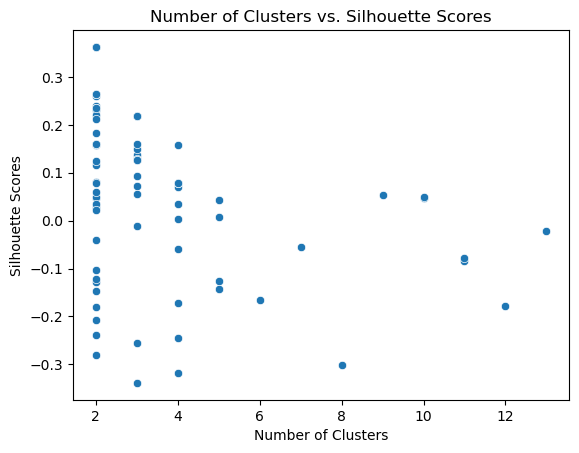

In [195]:
# Code adapted from ANLY501 lab-5.2 authored by Alex Pattarini
test_eps = np.linspace(0.1,6,120)
test_min_samples = np.linspace(2,21,20)

sil_scores = []
clusters_nums = []
best_sil_score = -1

for ep in test_eps:
    for min_sample in test_min_samples:
        try:
            model = DBSCAN(eps=ep,min_samples=int(min_sample)).fit(X)
            labels = model.labels_
            #print(labels)
            # Silhouette score
            sil_score = silhouette_score(X,labels)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0) # Adapted from https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html
            n_noise = list(labels).count(-1)
            # 1 cluster is a trivial solution, so any models that result in a 1 cluster solution are disregarded
            if n_clusters != 1:
                sil_scores.append(sil_score)
                clusters_nums.append(n_clusters)
                # If this sil score is better than prior scores, save info of best eps and min sample
                if sil_score > best_sil_score:
                    best_sil_score = sil_score
                    best_eps = ep
                    best_min_samples = min_sample
                    best_n_clusters = n_clusters
            #print(n_clusters)
            #print("SUCCESS")
        except:
            # Parameter test is invalid/produces unusable output (either too many or too few clusters)
            a=1
# Plot of silhouette score vs num clusters
#clusters_nums=np.array(clusters_nums)
#sil_scores=np.array(sil_scores)
# Plot of silhouette score vs num clusters
print("BASED ON SILHOUETTE SCORES CALCULATED ABOVE:")
print("The best number of clusters is: "+str(best_n_clusters))
print("The best eps value is: "+str(best_eps))
print("The best min_samples value is: "+str(best_min_samples))
print("With a silhouette score of: "+str(best_sil_score))

df = pd.DataFrame()
df['Silhouette_Scores'] = sil_scores
df['Number_of_Clusters'] = clusters_nums
# print(df)
fig = plt.subplot()
sns.scatterplot(x='Number_of_Clusters',y='Silhouette_Scores',data=df)
plt.title("Number of Clusters vs. Silhouette Scores")
plt.ylabel("Silhouette Scores")
plt.xlabel("Number of Clusters")
plt.show()

The optimal number of clusters is 2.

## Results of DBSCAN Clustering

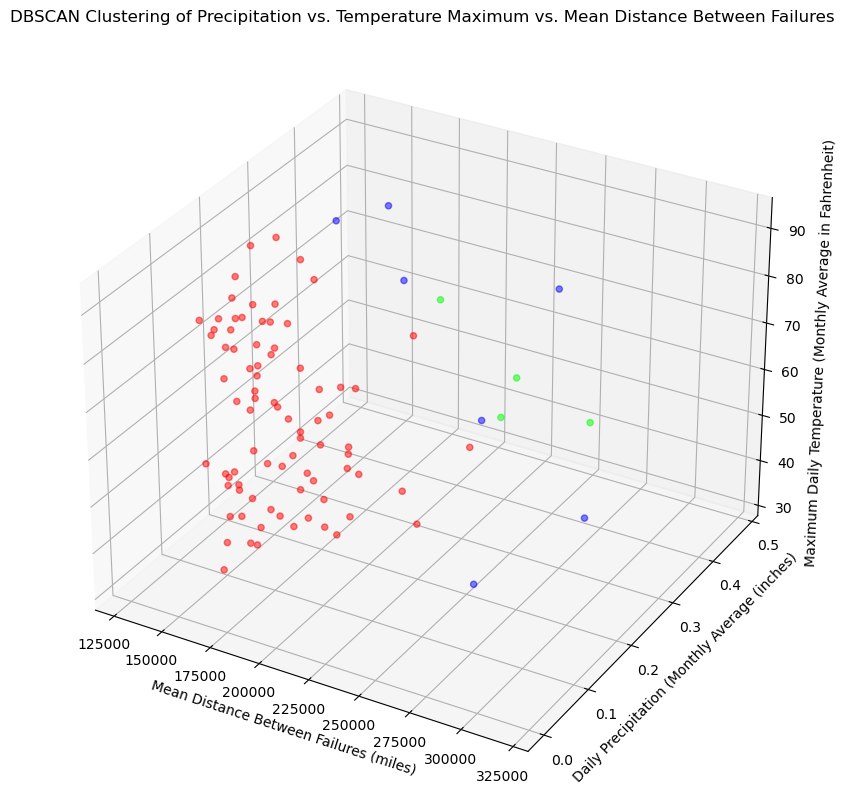

In [196]:
# Final DBSCAN model with parameters above
model = DBSCAN(eps=best_eps,min_samples=int(best_min_samples))
y_dbscan = model.fit_predict(X)
labels = model.labels_

u_X = scaler.inverse_transform(X)
# Plot clusters
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(u_X[:,0], u_X[:,1],u_X[:,2], c=y_dbscan, cmap="brg",alpha=0.5)
ax.set_title("DBSCAN Clustering of Precipitation vs. Temperature Maximum vs. Mean Distance Between Failures")
ax.set_xlabel("Mean Distance Between Failures (miles)")
ax.set_zlabel("Maximum Daily Temperature (Monthly Average in Fahrenheit)")
ax.set_ylabel("Daily Precipitation (Monthly Average (inches)")
plt.show()

The above plot shows the resulting clusters after constructing and applying a DBSCAN model with the best epsilon and minimum sample hyperparameters found via hyperparameter tuning earlier in this document. Please note that the blue points are noise points, or "outliers" of sorts that are not associated with any cluster. This means that these points are not within the epsilon value (in terms of distance) from the clusters pictured in red and green.

# Hierarchical Clustering

## Hyperparameter Tuning

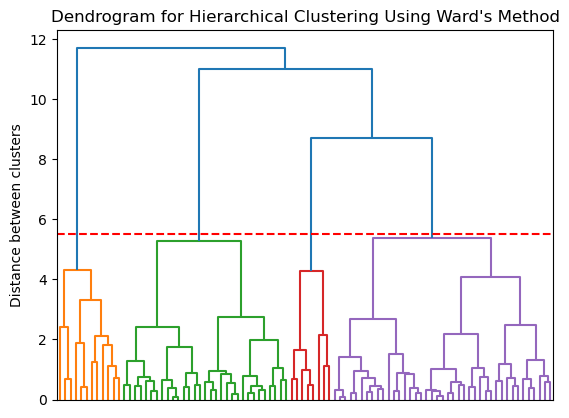

The optimal number of clusters based on the Ward's method dendrogram is 4


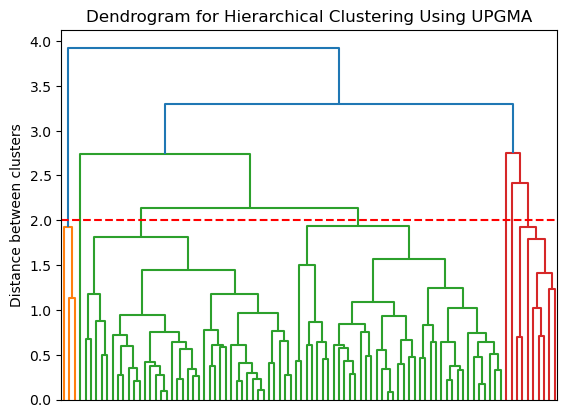

The optimal number of clusters based on the UPGMA dendrogram is 3


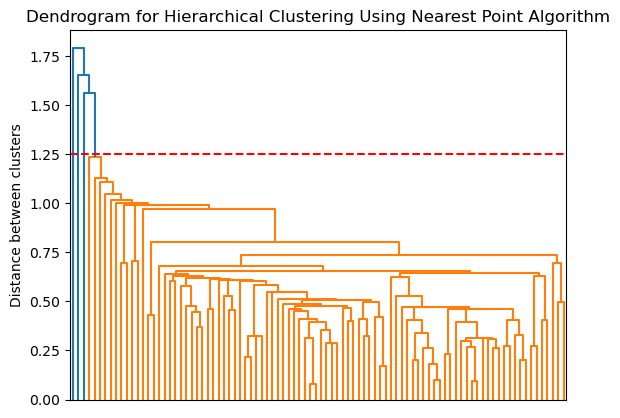

The optimal number of clusters based on the Nearest Point dendrogram is 2


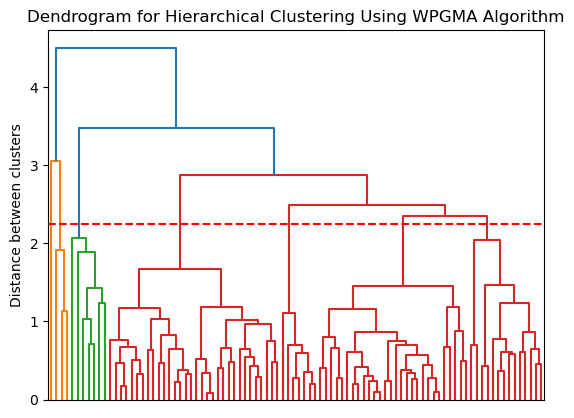

The optimal number of clusters based on the WPGMA dendrogram is 3


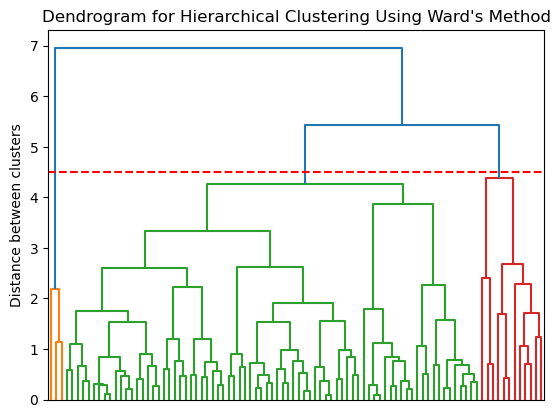

The optimal number of clusters based on the complete method dendrogram is 3


In [197]:
# Plot Ward's Method Dendrogram
fig,ax = plt.subplots()
Z = linkage(X, method='ward') 
dendro = dendrogram(Z)
plt.axhline(y=5.5, color='r', linestyle='--', label='5.5')
ax.set_title("Dendrogram for Hierarchical Clustering Using Ward's Method")
ax.set_xticklabels([])
ax.set_ylabel("Distance between clusters")
plt.show()
print("The optimal number of clusters based on the Ward's method dendrogram is 4")

# Plot average method dendrogram
fig,ax = plt.subplots()
Z = linkage(X, method='average') 
dendro = dendrogram(Z)
plt.axhline(y=2, color='r', linestyle='--', label='2')
ax.set_title("Dendrogram for Hierarchical Clustering Using UPGMA")
ax.set_xticklabels([])
ax.set_ylabel("Distance between clusters")
plt.show()
print("The optimal number of clusters based on the UPGMA dendrogram is 3")

# Plot single method dendrogram
fig,ax = plt.subplots()
Z = linkage(X, method='single') 
dendro = dendrogram(Z)
plt.axhline(y=1.25, color='r', linestyle='--', label='1.25')
ax.set_title("Dendrogram for Hierarchical Clustering Using Nearest Point Algorithm")
ax.set_xticklabels([])
ax.set_ylabel("Distance between clusters")
plt.show()
print("The optimal number of clusters based on the Nearest Point dendrogram is 2")

# Plot weighted method dendrogram
fig,ax = plt.subplots()
Z = linkage(X, method='weighted') 
dendro = dendrogram(Z)
plt.axhline(y=2.25, color='r', linestyle='--', label='2.25')
ax.set_title("Dendrogram for Hierarchical Clustering Using WPGMA Algorithm")
ax.set_xticklabels([])
ax.set_ylabel("Distance between clusters")
plt.show()
print("The optimal number of clusters based on the WPGMA dendrogram is 3")

# Plot Complete Method Dendrogram
fig,ax = plt.subplots()
Z = linkage(X, method='complete') 
dendro = dendrogram(Z)
plt.axhline(y=4.5, color='r', linestyle='--', label='4.5')
ax.set_title("Dendrogram for Hierarchical Clustering Using Ward's Method")
ax.set_xticklabels([])
ax.set_ylabel("Distance between clusters")
plt.show()
print("The optimal number of clusters based on the complete method dendrogram is 3")

Talk about each dendrogram (maximizing distance between clusters is good, so Ward is best, thus 4 clusters)

## Result of Hierarchical Clustering

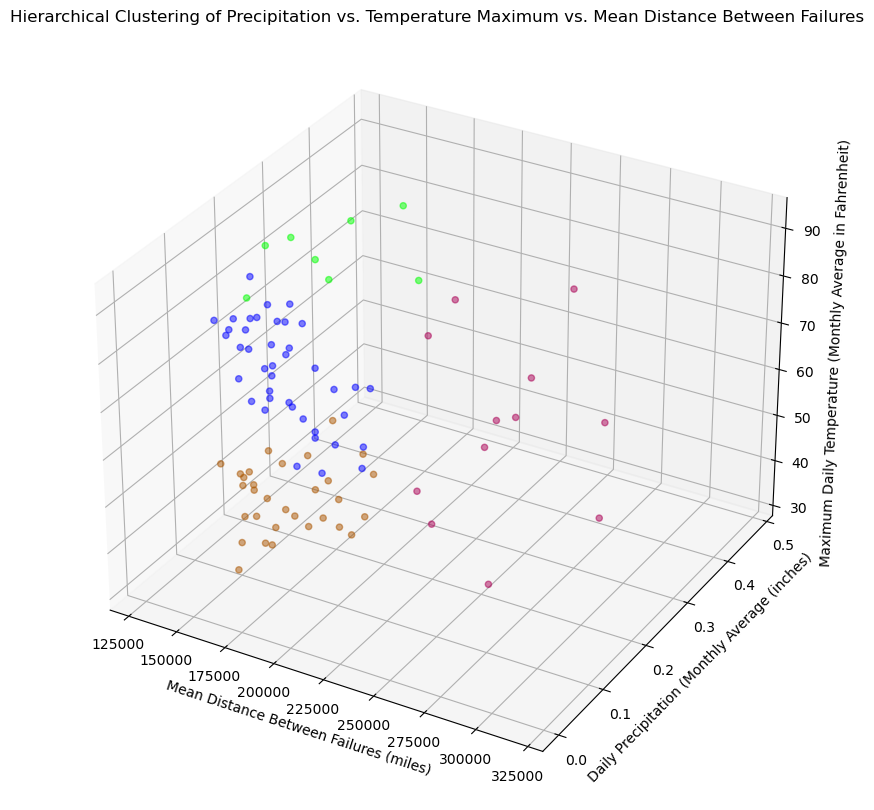

In [198]:
model = AgglomerativeClustering(n_clusters=4).fit(X)
labels = model.labels_
y_hac = model.fit_predict(X)

u_X = scaler.inverse_transform(X)
# Plot clusters
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(u_X[:,0], u_X[:,1],u_X[:,2], c=y_hac, cmap="brg",alpha=0.5)
ax.set_title("Hierarchical Clustering of Precipitation vs. Temperature Maximum vs. Mean Distance Between Failures")
ax.set_xlabel("Mean Distance Between Failures (miles)")
ax.set_zlabel("Maximum Daily Temperature (Monthly Average in Fahrenheit)")
ax.set_ylabel("Daily Precipitation (Monthly Average (inches)")
plt.show()

## Overall Results

## Conclusions

## References